This code takes a multichannel Tiff generated from the MCD files by the MCD_2_TIFF notebook file, and applies the multichannel mask generated in imageJ using the mask gen macro. As the mask file has a channel per egg, dataframes can be generated with per egg data. There is code for a wide format dataframe (one row per egg, useful for analysis in excel or python), and in long format (one row per datapoint, suitable for plotting graphs in python). There is a line after each dataframe is generated to save it as a CSV file.

You should be in an environment that has numpy, matplotlib, python image library (PIL), and seaborn (if you want to plot data using the code after dataframe generation).

In [1]:

#Import packages needed to process data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import pandas as pd

import seaborn as sns

The next couple boxes are a quick check to make sure the images are looking like we expect (optional). They will display the first 4 masks and first 4 eggs using matplotlib. The read tiff function is needed to open a multichannel tiff, iterate through the channels, and create a numpy array of arrays. There is no inbuilt functionality for this. 

In [2]:
#Read the list of protein names from the Panel CSV file. Check your panel file is correct for this experiment#

metals = list(pd.read_csv('Panel6.csv')['name'])

metals

['gH2AX',
 'CDK1',
 'Wee1',
 'p4E-BP1',
 'CyclinB1',
 'ZW10',
 'pStat3',
 'p21',
 'Ki67',
 'Tubulin',
 'CyclinA2',
 'PLK1',
 'Securin',
 'pCDC25B',
 'Separase',
 'PhosphoH3',
 'DNA',
 'DNA']

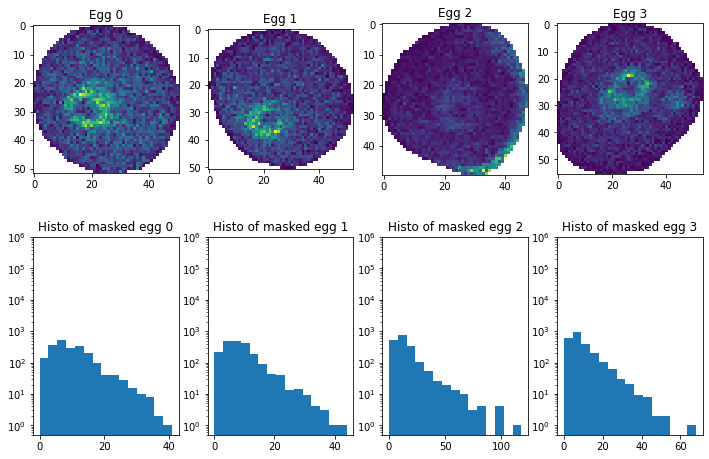

In [5]:
##optional, just to check you're getting egg images correctly

#The metals list is your panel in order. t is the max threshhold for each metal used for displaying the data in the plots. 
#In this cell the purpose of the code is a quick check of the data so will always just look at the first channel.


def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

multimask = read_tiff("ProphaseMask.tif") ################### change this to your first roi's individual eggs mask ###############
multi = read_tiff("Prophase.tiff") ############################  change this to your first roi ###################################

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(12,8)) # This is how you initiate a multiplot

for i in range(0,4): ## This for loop iterates through the first 4 eggs, plotting the image and histogram below it.
    
    mask_arr = np.array(multimask[i]) # Choose the mask 
    mask_df = pd.DataFrame(mask_arr)  # Turn the mask into a dataframe for easy mask application to the actual image
    
    df=pd.DataFrame(multi[0])##   only using target 0 (gH2AX) in this example. Turns image array into dataframe for mask application
    tightdf=df[mask_df == 255].dropna(how='all').dropna(how='all',axis=1) # Applies the mask, and drops all rows/columns that are empty

    ax[0,i].imshow(tightdf,interpolation='nearest') ## Plots image. add .fillna(0) to have dark background (zeros). vmax sets bightness ceiling
    ax[0,i].set_title("Egg "+str(i))

    x = df[mask_df == 255].to_numpy().flatten() # Applies mask again, converting pixels oputside of egg to NaN, then to a numpy array and flattens to list
    x2= x[~np.isnan(x)] # removes NaN values from flattened array, leaving a list of values from inside the egg

    ax[1,i].hist(x2,bins=15) # plots a histogram of the list of values inside the egg generated above
    ax[1,i].set_title('Histo of masked egg '+str(i))
    ax[1,i].set_yscale('log')
    ax[1,i].set_ylim(0.5, 1000000)
    #ax[1,i].set_xlim(0, 100) # You might want to remove or edit this if looks like histogram's x axis scale is off

If you ran the above two cells, you should see your first four cells and their corresponding histograms

Below is the code to generate the dataframes from the images. The code is written in this notebook redundantly, so other than importing the packages at the start, these cells can be copy and pasted and ran independently of anything previous to this. 

In [6]:
%%time
  ########## Putting the total signal data into a wide format dataframe #########
  ##---------------------------------------------------------------------------##


## This code expects a tiff (or tiffs) of timepoint(s) named in the format [timepoint.tiff] eg "5.5hr.tiff",
## and a mask .tif for each timepoint named as above but including the word Mask at the end, eg. "5.5hrMask.tif" NB .tif due to imageJ output


##IMPORTANT!!!! SET TIMEPOINTS HERE, add timepoints as strings separated by commas (python list)
times = ["Prophase", '2hr', '3.5hr', '5hr', "6.5hr", '7.5hr','NoGVBD']

metals = list(pd.read_csv('Panel6.csv')['name']) #set your panel file here (the .csv part, don't edit the actaul word 'name' in this code)


##Funtion to read multichannel tiff in as numpy array
##############
def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)
###############



##Create the empty wide format data frame. CUSTOMISE METALS AS APPROPRIATE #####  ########  ################
ColumnsWide = 'IntraEggId Timepoint'.split()
ColumnsWide = ColumnsWide + metals
widedf = pd.DataFrame(columns=ColumnsWide)



for timepoint in times:
    ##Read Egg image in and masks in.  ######## THIS ASSUMES YOU HAVE FOLLOWED THE FILE NAME STRUCTURE OUTLINED AT TOP ###########
    multi = read_tiff(timepoint+".tiff") 
    multimask = read_tiff(timepoint+"Mask.tif")
    EggCount = multimask.shape[0] ##How many channels are in the mask, ie number of cells are we going to be iterating through?

    

    ##Populate rows with Egg data
    for x in range(EggCount):
        NewRow = [] ## Empty list that will become new row
        NewRow.append(x) ## First column is EggID
        NewRow.append(timepoint) ## Second column is egg timepoint
        EggMask = multimask[x] ## Focuses on the mask with the right egg in it
    
        for metal in range(len(metals)):
            metaldf=pd.DataFrame(multi[metal]) ##Focuses on one metal channel at a time, turning np array into DataFrame so it can be masked with another DF
            lineararray = metaldf[EggMask == 255].to_numpy().flatten() ##Applies mask and flattens data to a 1D array
            linearnoNaN = lineararray[~np.isnan(lineararray)] ##Removes NaN values that were placed in area outside of mask by above line
            NewRow.append(sum(linearnoNaN))  ## Adds the sum of that metal's signal to the list which will become the new DF row      
    

        widedf.loc[len(widedf.index)] = NewRow ## Adds the 'NewRow' list of data generated above to the DF as a new row
    
widedf

Wall time: 1min 34s


,IntraEggId,Timepoint,gH2AX,CDK1,Wee1,p4E-BP1,CyclinB1,ZW10,pStat3,p21,Ki67,Tubulin,CyclinA2,PLK1,Securin,pCDC25B,Separase,PhosphoH3,DNA,DNA
0,0,Prophase,3709150,8078680,2006338,1028230,1875372,2705162,3420201,1206541,3355322,411745635,1597215,5324104,3110839,3968713,3661013,1206846,682386,1271593
1,1,Prophase,3742668,8138955,1803796,969817,1772078,2842669,3182635,1157753,3264231,448538279,1712899,5780572,3894533,4286909,3929857,1224681,726983,1360510
2,2,Prophase,2297719,5298284,1131621,602867,972863,1548725,1801842,656003,1756880,232944226,909056,3477072,3263769,2242240,2106033,799646,416802,775553
3,3,Prophase,4321210,8230751,1780963,887951,1999625,3826940,3801765,1405911,4110963,670466853,2499240,8771937,5815611,5961910,5976832,1304891,1007147,1862137
4,4,Prophase,4318561,7976249,1717845,845264,2004853,3940411,3789331,1405868,4178053,698324803,2573187,9003344,6067475,6163657,6155413,1302226,1042170,1914588
5,5,Prophase,3321982,6036060,1357116,645733,1581249,2928281,3031184,1051935,3224144,518963914,1847341,6607756,4609042,4450469,4466131,1094487,760893,1393212
6,6,Prophase,3566810,7640766,1868882,888112,1740286,2484587,3395674,1101478,3196697,384549526,1476182,5262084,3482206,3874014,3916379,1190431,592799,1087015
7,7,Prophase,3798976,8664932,2164241,1039406,2017705,2662455,3876665,1293192,3672062,405761925,1601728,5993931,3895931,4446194,4272401,1214045,656343,1218927
8,0,2hr,2811640,4983287,2433110,369488,1205018,4487491,2929651,921261,2963454,697561830,1871928,9100323,6333684,4602047,11186210,43921912,897783,1630593
9,1,2hr,3053920,5792250,2897759,432586,1402329,5311808,3539070,1088634,3373031,788503135,2157753,10921429,7991767,5403875,12898691,47062743,1351633,2477934


In [13]:
##uncomment and run this to save the dataframe as a csv, calling it whatever you want

#widedf.to_csv('IMC_Wide_Dataframe.csv') 

In [ ]:
##uncomment and run this to open the dataframe from the .csv if you have done that previously, make sure the name is correct

#widedf = pd.read_csv('IMC_Wide_Dataframe.csv')  

In [8]:
%%time
  ########## Putting the total signal data into a long format dataframe #########
  ##---------------------------------------------------------------------------##

## This code expects a tiff (or tiffs) of timepoint(s) named in the format [timepoint.tiff] eg "5.5hr.tiff",
## and a mask .tif for each timepoint named as above but including the word mask at the end, eg. "5.5hrMask.tif" NB .tif due to imageJ output.

##Check the imported packages at the top


##IMPORTANT!!!! SET TIMEPOINTs HERE, add timepoints as strings separated by commas (python list)
times = ["Prophase", '2hr', '3.5hr', '5hr', "6.5hr", '7.5hr']

metals = list(pd.read_csv('Panel6.csv')['name'])

##Funtion to read multichannel tiff in as numpy array
##############
def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)
###############




##Create the empty long format data frame. Creates a new line per datapoint
Columnslong = 'IntraEggId Timepoint Target Total_Signal'.split()
longdf = pd.DataFrame(columns=Columnslong)

for timepoint in times:
    ##Read Egg image in and masks in
    multi = read_tiff(timepoint+".tiff") 
    multimask = read_tiff(timepoint+"Mask.tif")
    EggCount = multimask.shape[0] ##How many channels are in the mask, ie eggs are we going to be iterating through?

    

    ##Populate rows with Egg data
    for x in range(EggCount):
        EggMask = multimask[x] ## Focuses on the mask with the right egg in it
    
        for metal in range(len(metals)):
            NewRow = [] ## Empty list that will become new row
            NewRow.append(x) ## First column is EggID
            NewRow.append(timepoint) ## Second column is egg timepoint
            NewRow.append(metals[metal]) ## Third column is protein
            
            metaldf=pd.DataFrame(multi[metal]) ##Focuses on one metal channel at a time, turning np array into DataFrame so it can be masked with another DF
            lineararray = metaldf[EggMask == 255].to_numpy().flatten() ##Applies mask and flattens data to a 1D array
            linearnoNaN = lineararray[~np.isnan(lineararray)] ##Removes NaN values that were placed in area outside of mask by above line
            NewRow.append(sum(linearnoNaN))  ## Adds the sum of that metal's signal to the list which will become the new DF row      
            
            longdf.loc[len(longdf.index)] = NewRow ## Adds the 'NewRow' list of data generated above to the DF as a new row

        
    
longdf

Wall time: 1min 31s


,IntraEggId,Timepoint,Target,Total_Signal
0,0,Prophase,gH2AX,3709150
1,0,Prophase,CDK1,8078680
2,0,Prophase,Wee1,2006338
3,0,Prophase,p4E-BP1,1028230
4,0,Prophase,CyclinB1,1875372
...,...,...,...,...
751,4,7.5hr,pCDC25B,2970143
752,4,7.5hr,Separase,2600079
753,4,7.5hr,PhosphoH3,3134331
754,4,7.5hr,DNA,310525


In [15]:
##uncomment and run this to save the dataframe as a csv, calling it whatever you want
#longdf.to_csv('IMC_Long_Dataframe.csv')



This is the end of the code necessary to generate the dataframes and save them as CSV files. In the code below the data (from the long format dataframe) is plotted using seaborn.


In [ ]:
##uncomment and run this to open the dataframe from the .csv if you have done that previously, make sure the name is correct
#longdf = pd.read_csv('IMC_Long_Dataframe.csv')

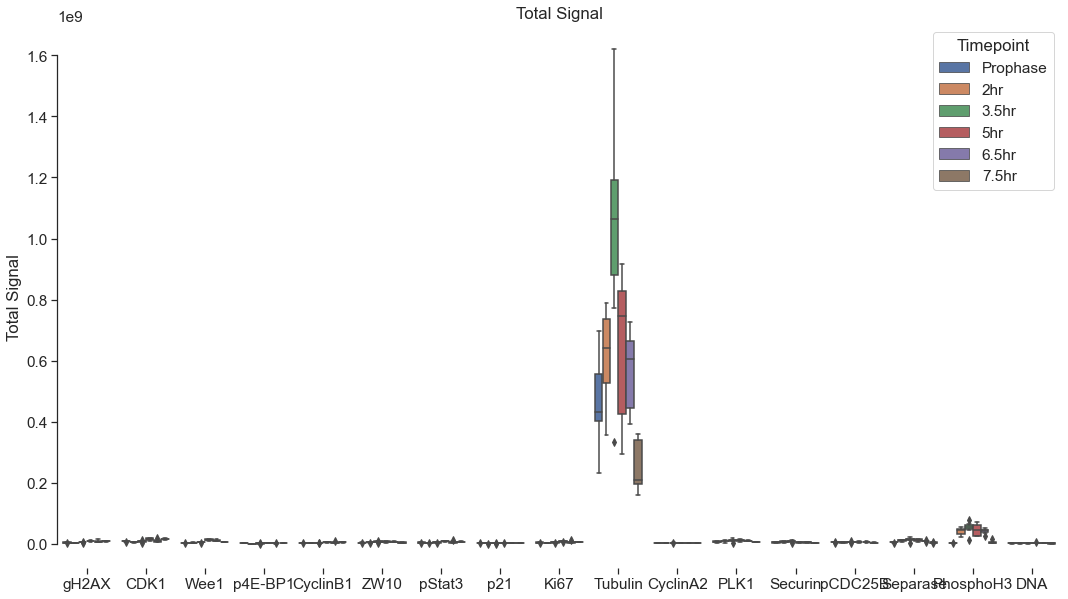

In [13]:
## This generates a boxplot, excluding the 2 DNA channels as they are not quantitative data (and probably didn't work anyway).

##If one channel is overpowering, such as tubulin, you can use something like longdf2 instead of longdf. (Or exclude any channel you want)
#longdf2 = longdf[(longdf["Target"] != "Tubulin")]

##Exclude multiple channels usig the below format
#longdf3 = longdf[(longdf["Target"] != "Tubulin") & (longdf["Target"] != "PhosphoH3")]



sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.4)
sns.set_style("ticks")
#sns.set_style('white')

ax4=sns.boxplot(x='Target', y='Total_Signal', hue='Timepoint', data=longdf) #replace longdf with uncommented longdf2/3 if you want to plot that instead
ax4.set(xlabel='',
       ylabel='Total Signal',
       title='Total Signal')
sns.despine(bottom=True,trim = True)

#plt.savefig("Whole Egg Signal Boxplot.png", dpi=600)

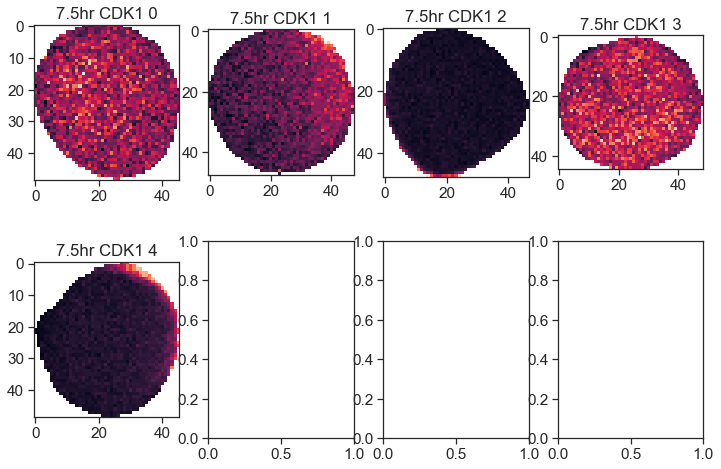